# Final Project 
## Complete Machine Learning Pipeline for MIMIC Classification

### Mariajose Argote


In [337]:
EDA = True

### Objective
Build a classification pipeline to predict `HOSPITAL_EXPIRE_FLAG` (patient mortality during ICU stay) using the MIMIC-III dataset subset with 20,885 ICU patient observations.

### Success Criteria
- Working, reproducible Jupyter notebook with complete ML pipeline
- Predictions submitted as probabilities (.predict_proba) in CSV format
- Top-tier prediction ranking (within reasonable distance of best performer)
- Ability to defend all modeling decisions during in-person presentation
- Grade target: 9/10 from presentation + up to 1/10 from prediction ranking

In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [339]:
# Generate a random seed for reproducibility
# np.random.seed() has a range of [0, 2**32 - 1] for the seed value
print(np.random.randint(0, 2**30))

SEED = 244459055

np.random.seed(SEED)
#540921260


540921260


### 1.1 Import MIMIC Data

In [340]:
# Import data

train = pd.read_csv('MIMIC III dataset HEF/mimic_train_HEF.csv')
test= pd.read_csv('MIMIC III dataset HEF/mimic_test_HEF.csv')


# Display first few rows of the dataset

print(train.info())

train.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
count,20885.000000,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,...,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000
mean,0.112282,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,...,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046
std,0.315720,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,...,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721
min,0.000000,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,...,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600
25%,0.000000,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,...,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400
50%,0.000000,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,...,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800
75%,0.000000,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,...,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800
max,1.000000,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,...,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000


In [341]:
train.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


### 1.2 Check data types, missing values, distributions

Visual Inspection
* 10% of heart rate and blood pressure columns are missing / blank
* 11% of SYS and DiasBP columns are missing /blank
* 10% missing respiration rate columns
* 12% missing temperature information
* 11% missing SPO2 columns information


In [342]:
print(test.info())
test.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5221 entries, 0 to 5220
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      5221 non-null   int64  
 1   hadm_id         5221 non-null   int64  
 2   icustay_id      5221 non-null   int64  
 3   HeartRate_Min   4676 non-null   float64
 4   HeartRate_Max   4676 non-null   float64
 5   HeartRate_Mean  4676 non-null   float64
 6   SysBP_Min       4670 non-null   float64
 7   SysBP_Max       4670 non-null   float64
 8   SysBP_Mean      4670 non-null   float64
 9   DiasBP_Min      4669 non-null   float64
 10  DiasBP_Max      4669 non-null   float64
 11  DiasBP_Mean     4669 non-null   float64
 12  MeanBP_Min      4674 non-null   float64
 13  MeanBP_Max      4674 non-null   float64
 14  MeanBP_Mean     4674 non-null   float64
 15  RespRate_Min    4675 non-null   float64
 16  RespRate_Max    4675 non-null   float64
 17  RespRate_Mean   4675 non-null   f

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
count,5221.000000,5221.000000,5221.000000,4676.000000,4676.000000,4676.000000,4670.000000,4670.000000,4670.000000,4669.000000,...,4583.000000,4583.000000,4583.000000,4670.000000,4670.000000,4670.000000,5163.000000,5163.000000,5163.000000,5221.000000
mean,58870.629573,150248.186746,249925.293239,69.942686,105.279940,85.221128,90.862392,150.547966,118.763143,44.142643,...,36.041879,37.441470,36.755418,90.828480,99.553319,96.857538,107.823494,376.578346,163.521697,-51606.334303
std,25320.956194,28679.538155,28763.030681,15.013524,21.247956,15.484126,17.529140,23.575450,16.490767,11.695481,...,0.762967,0.797153,0.595941,7.660437,1.516541,2.406957,34.312518,13915.510710,1739.829727,10666.881712
min,107.000000,100033.000000,200011.000000,1.000000,42.000000,36.000000,10.000000,62.000000,51.750000,6.000000,...,22.777778,32.555556,32.222222,1.000000,42.000000,42.000000,15.000000,32.000000,32.000000,-72639.620300
25%,41055.000000,125246.000000,225118.000000,60.000000,90.000000,74.035131,81.000000,134.000000,106.752976,37.000000,...,35.666667,36.944444,36.409722,90.000000,100.000000,95.840227,87.000000,126.000000,111.500000,-60840.730090
50%,60057.000000,150492.000000,249759.000000,69.000000,104.000000,83.957428,90.000000,148.000000,116.807407,44.000000,...,36.111111,37.333333,36.738095,92.000000,100.000000,97.134848,102.000000,160.000000,129.000000,-51612.812060
75%,80313.000000,174983.000000,274576.000000,79.000000,118.000000,95.477143,101.000000,164.000000,128.862844,51.000000,...,36.500000,37.888889,37.091705,94.000000,100.000000,98.333333,122.000000,205.000000,155.060976,-42552.065720
max,99992.000000,199967.000000,299979.000000,143.000000,220.000000,155.571429,162.000000,290.000000,195.250000,97.000000,...,39.388889,41.111111,39.527778,100.000000,100.000000,100.000000,374.000000,999999.000000,125110.125000,-32176.628480


In [343]:
# Check train/test column consistency
target_col = "HOSPITAL_EXPIRE_FLAG"
leaky_cols = ['LOS', 'DOD', 'DISCHTIME','DEATHTIME'] #must drop for modeling
id_cols      = ["subject_id", "hadm_id", "icustay_id"]

# Groups 
vital_cols = [  # 24 cols: min/max/mean of each
    
    "HeartRate_Min", "HeartRate_Max", "HeartRate_Mean",
    "SysBP_Min", "SysBP_Max", "SysBP_Mean",
    "DiasBP_Min", "DiasBP_Max", "DiasBP_Mean",
    "MeanBP_Min", "MeanBP_Max", "MeanBP_Mean",
    "RespRate_Min", "RespRate_Max", "RespRate_Mean",
    "TempC_Min", "TempC_Max", "TempC_Mean",
    "SpO2_Min", "SpO2_Max", "SpO2_Mean",
    "Glucose_Mean", "Glucose_Max", "Glucose_Min"
]

temporal_cols = ["DOB", "ADMITTIME", "DISCHTIME", "Diff"]

demographic_cols = ["GENDER", "ADMISSION_TYPE", "INSURANCE",
             "RELIGION", "MARITAL_STATUS", "ETHNICITY"]

clinical_cols = ["DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]


# Columns to use as features in train
exclude_cols = set([target_col]) | set(leaky_cols) | set(id_cols)
feature_cols = [c for c in train.columns if c not in exclude_cols]

# Working copy and drop giveaways up front
train = train.copy()
train_model = train.drop(columns=leaky_cols, errors="ignore")

In [344]:

# 1) Check that test has all feature columns
missing_in_test = set(feature_cols) - set(test.columns)
extra_in_test   = set(test.columns) - set(feature_cols)
print("Missing in test:", missing_in_test)
print("Extra in test  :", extra_in_test)

# 2) Reorder test columns to match train's feature order
test = test[feature_cols]


#checking for column type consistency
shared = set(train_model.columns) & set(test.columns)
dtype_diff = {
    col: (train_model[col].dtype, test[col].dtype)
    for col in shared
    if train_model[col].dtype != test[col].dtype
}
print("Columns with different dtypes:", dtype_diff)


Missing in test: set()
Extra in test  : {'subject_id', 'hadm_id', 'icustay_id'}
Columns with different dtypes: {}


In [345]:
#Check missing values - columns

def missing_summary(train):
    n = len(train)
    miss_cnt = train.isna().sum()
    miss_pct = miss_cnt / n
    return (
        pd.DataFrame({
            "n_missing": miss_cnt,
            "pct_missing": miss_pct
        })
        .sort_values("pct_missing", ascending=False)
    )

col_missing = missing_summary(train.drop(columns=id_cols, errors="ignore")
                              .drop(columns=leaky_cols, errors="ignore"))
print(col_missing.head(15))

#Check missing values - rows
row_missing_count = train_model.isna().sum(axis=1)
row_missing_frac  = row_missing_count / train_model.shape[1]

print("Rows with ANY missing:", (row_missing_count > 0).mean())
print("Rows with > 20% missing:", (row_missing_frac > 0.2).mean())
print("Rows with > 50% missing:", (row_missing_frac > 0.5).mean())


               n_missing  pct_missing
TempC_Max           2497     0.119559
TempC_Mean          2497     0.119559
TempC_Min           2497     0.119559
DiasBP_Max          2209     0.105770
DiasBP_Mean         2209     0.105770
DiasBP_Min          2209     0.105770
SysBP_Min           2208     0.105722
SysBP_Max           2208     0.105722
SysBP_Mean          2208     0.105722
SpO2_Max            2203     0.105482
SpO2_Min            2203     0.105482
SpO2_Mean           2203     0.105482
RespRate_Min        2189     0.104812
RespRate_Max        2189     0.104812
RespRate_Mean       2189     0.104812
Rows with ANY missing: 0.16322719655254966
Rows with > 20% missing: 0.10490782858510893
Rows with > 50% missing: 0.10452477854919799


In [346]:
#check if vital signs are missing together in rows

vital_cols_present = [c for c in vital_cols if c in train_model.columns] 

missing_vitals = train_model[vital_cols_present].isna()

# Fraction of rows with at least one missing vital
rows_any_vital_missing  = missing_vitals.any(axis=1)
# Fraction of rows with all vitals missing
rows_all_vitals_missing = missing_vitals.all(axis=1)

print("Frac rows with ANY vital missing   :", rows_any_vital_missing.mean().round(3))
print("Frac rows with ALL vitals missing  :", rows_all_vitals_missing.mean().round(3))

# See patterns of missingness across vitals
pattern_counts = missing_vitals.value_counts()
print(pattern_counts.head(10))


Frac rows with ANY vital missing   : 0.133
Frac rows with ALL vitals missing  : 0.0
HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  MeanBP_Max  MeanBP_Mean  RespRate_Min  RespRate_Max  RespRate_Mean  TempC_Min  TempC_Max  TempC_Mean  SpO2_Min  SpO2_Max  SpO2_Mean  Glucose_Mean  Glucose_Max  Glucose_Min
False          False          False           False      False      False       False       False       False        False       False       False        False         False         False          False      False      False       False     False     False      False         False        False          18113
True           True           True            True       True       True        True        True        True         True        True        True         True          True          True           True       True       True        True      True      True       False         False        False           

In [347]:
#exploring those rows where vitals are missing

# Count missing + present vitals per row
n_vitals_missing  = train_model[vital_cols].isna().sum(axis=1)
n_vitals_present  = train_model[vital_cols].notna().sum(axis=1)
frac_vitals_missing = n_vitals_missing / len(vital_cols)

# Quick sanity check:
print(n_vitals_missing.value_counts().sort_index().head(30))
print("Rows with 21 missing vitals:", (n_vitals_missing == 21).sum())

mask_21_missing = (n_vitals_missing == 21)

print("Mortality rate, 21-missing group:",
    train_model.loc[mask_21_missing, target_col].mean().round(3))

print("Mortality rate, others:",
  train_model.loc[~mask_21_missing, target_col].mean().round(3))

0     18113
3       545
6        36
9         3
12        2
15        1
18        2
21     2183
Name: count, dtype: int64
Rows with 21 missing vitals: 2183
Mortality rate, 21-missing group: 0.113
Mortality rate, others: 0.112


In [348]:
# Define threshold: drop rows with 21 or more missing vitals
THRESH_MISSING_VITALS = 21

mask_drop_extreme_vital_missing = (n_vitals_missing >= THRESH_MISSING_VITALS)

print("Dropping rows with >= 21 missing vitals:",
      mask_drop_extreme_vital_missing.mean().round(3), "of all rows")

train_model_clean = train_model.loc[~mask_drop_extreme_vital_missing].copy()


Dropping rows with >= 21 missing vitals: 0.105 of all rows


Because vital signs are central to our mortality prediction, I removed ICU stays where ≥ 87.5% of vital-sign summary features were missing (2,183 out of 20,885 stays). For the remaining patients, the plan is to impute the missing vitals using median/mean values within the training set.

In [349]:
#checking different dataframe sizes

print("train shape:", train.shape)
print("train_model shape:", train_model.shape)
print("train_model_clean shape:", train_model_clean.shape)

train_model_clean.head()

train shape: (20885, 44)
train_model shape: (20885, 40)
train_model_clean shape: (18702, 40)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
5,0,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,2151-08-06 19:11:00,-51044.77754,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU


In [350]:
#checking missing data by columns after clean drop

col_missing = missing_summary(train_model_clean.drop(columns=id_cols, errors="ignore"))
col_missing.head(20)


,n_missing,pct_missing
MARITAL_STATUS,683,0.036520
TempC_Mean,314,0.016790
TempC_Min,314,0.016790
TempC_Max,314,0.016790
Glucose_Max,253,0.013528
Glucose_Min,253,0.013528
Glucose_Mean,253,0.013528
DiasBP_Mean,26,0.001390
DiasBP_Max,26,0.001390
DiasBP_Min,26,0.001390


### 1.3 Identify and visualize class imbalance in target

88.8% of ICU stays survived in the cleaned training set, this indicates strong class imbalance in the target

In [351]:
train_model_clean[target_col].value_counts(normalize=True)

#88.8% of ICU stays survived in the cleaned training set


HOSPITAL_EXPIRE_FLAG
0    0.887819
1    0.112181
Name: proportion, dtype: float64

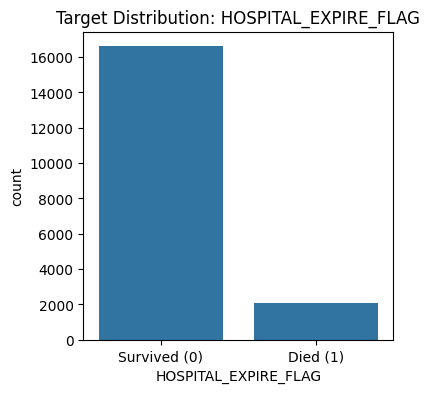

In [352]:
#plotting target distribution after cleaning

plt.figure(figsize=(4,4))
sns.countplot(x=target_col, data=train_model_clean)
plt.title("Target Distribution: HOSPITAL_EXPIRE_FLAG")
plt.xticks([0, 1], ["Survived (0)", "Died (1)"])
plt.show()


### 1.4 Examine correlations between vital signs

In [353]:
vitals_present = [c for c in vital_cols if c in train_model_clean.columns]

vital_means = [c for c in vitals_present if c.endswith("_Mean")]

train_model_clean[vital_means].describe()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
count,18698.000000,18677.000000,18676.000000,18699.000000,18696.000000,18388.000000,18682.000000,18449.000000
mean,85.180250,119.145423,62.511614,77.609535,18.985855,36.751717,96.866685,139.033918
std,15.318208,16.701503,11.010790,11.113299,3.849713,0.603476,2.333108,44.437267
min,34.714286,46.000000,17.000000,25.759907,9.291667,30.666667,47.666667,43.250000
25%,74.272727,107.100000,54.950952,70.033908,16.250000,36.388889,95.812500,111.000000
50%,84.131183,116.901961,61.423660,76.294118,18.382353,36.731481,97.142857,129.000000
75%,95.185588,129.465116,68.954545,84.041774,21.105543,37.092593,98.346154,155.000000
max,163.875000,202.172414,121.489362,136.652174,41.235294,40.238333,100.000000,771.900000


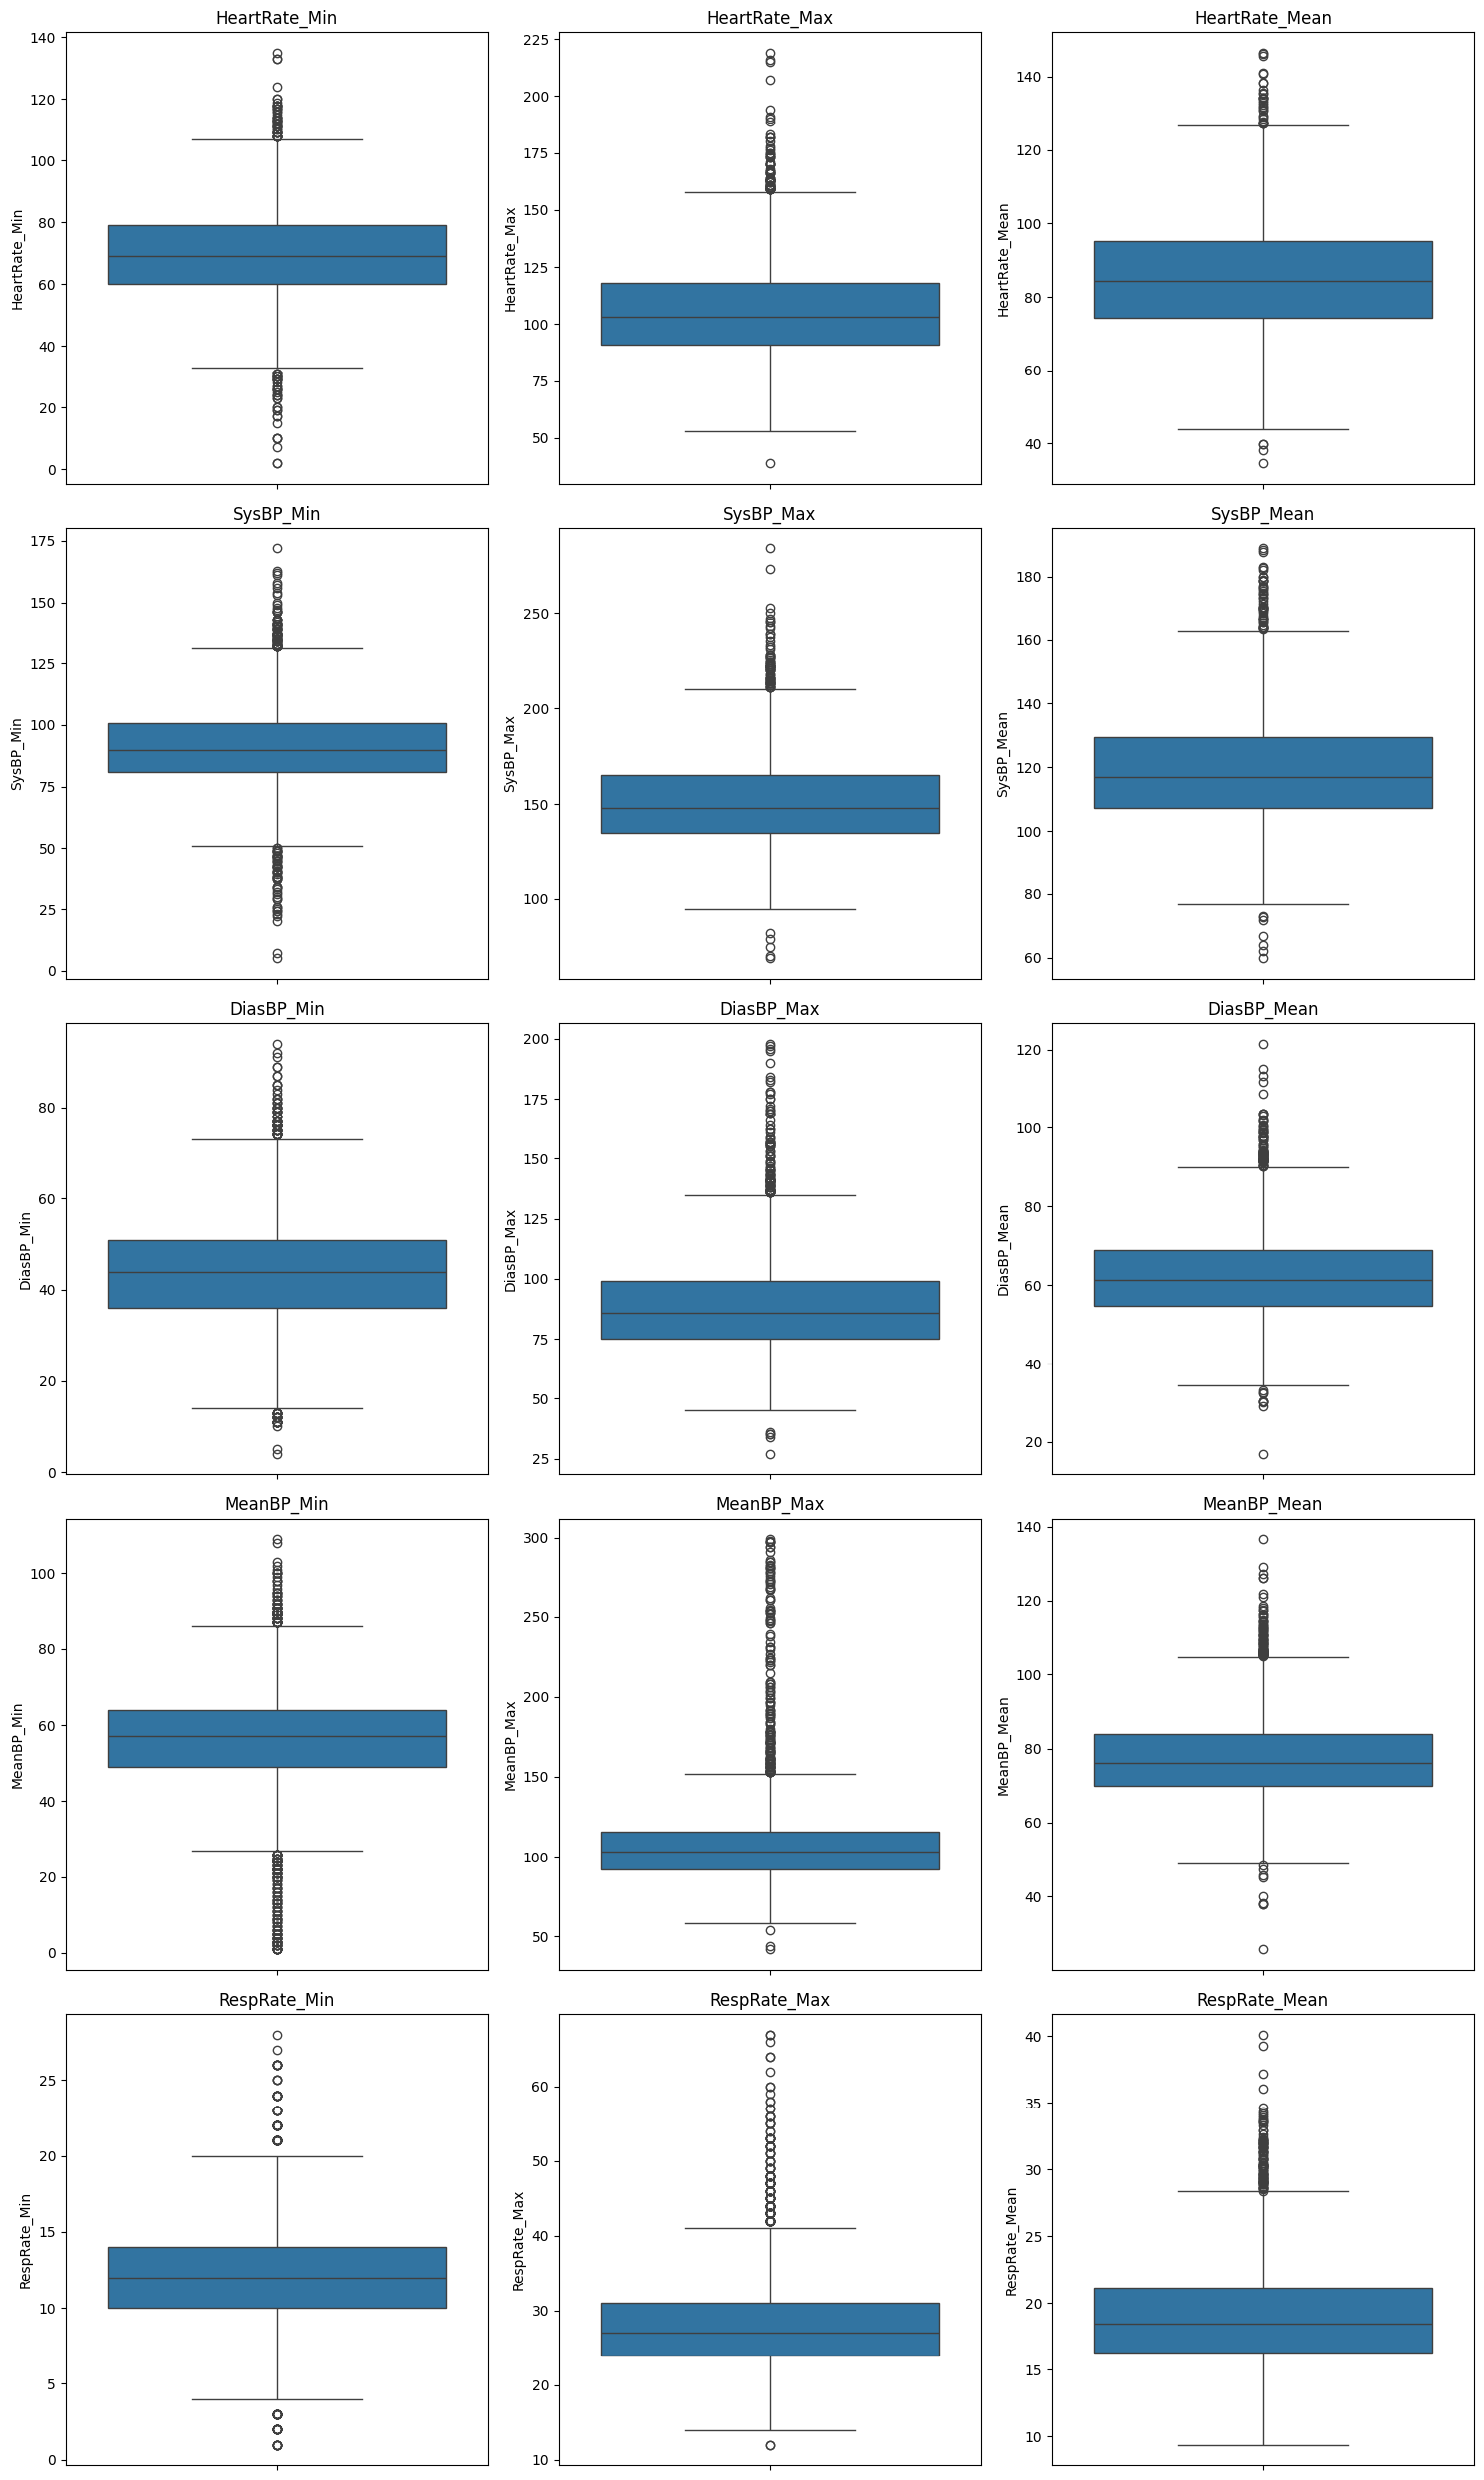

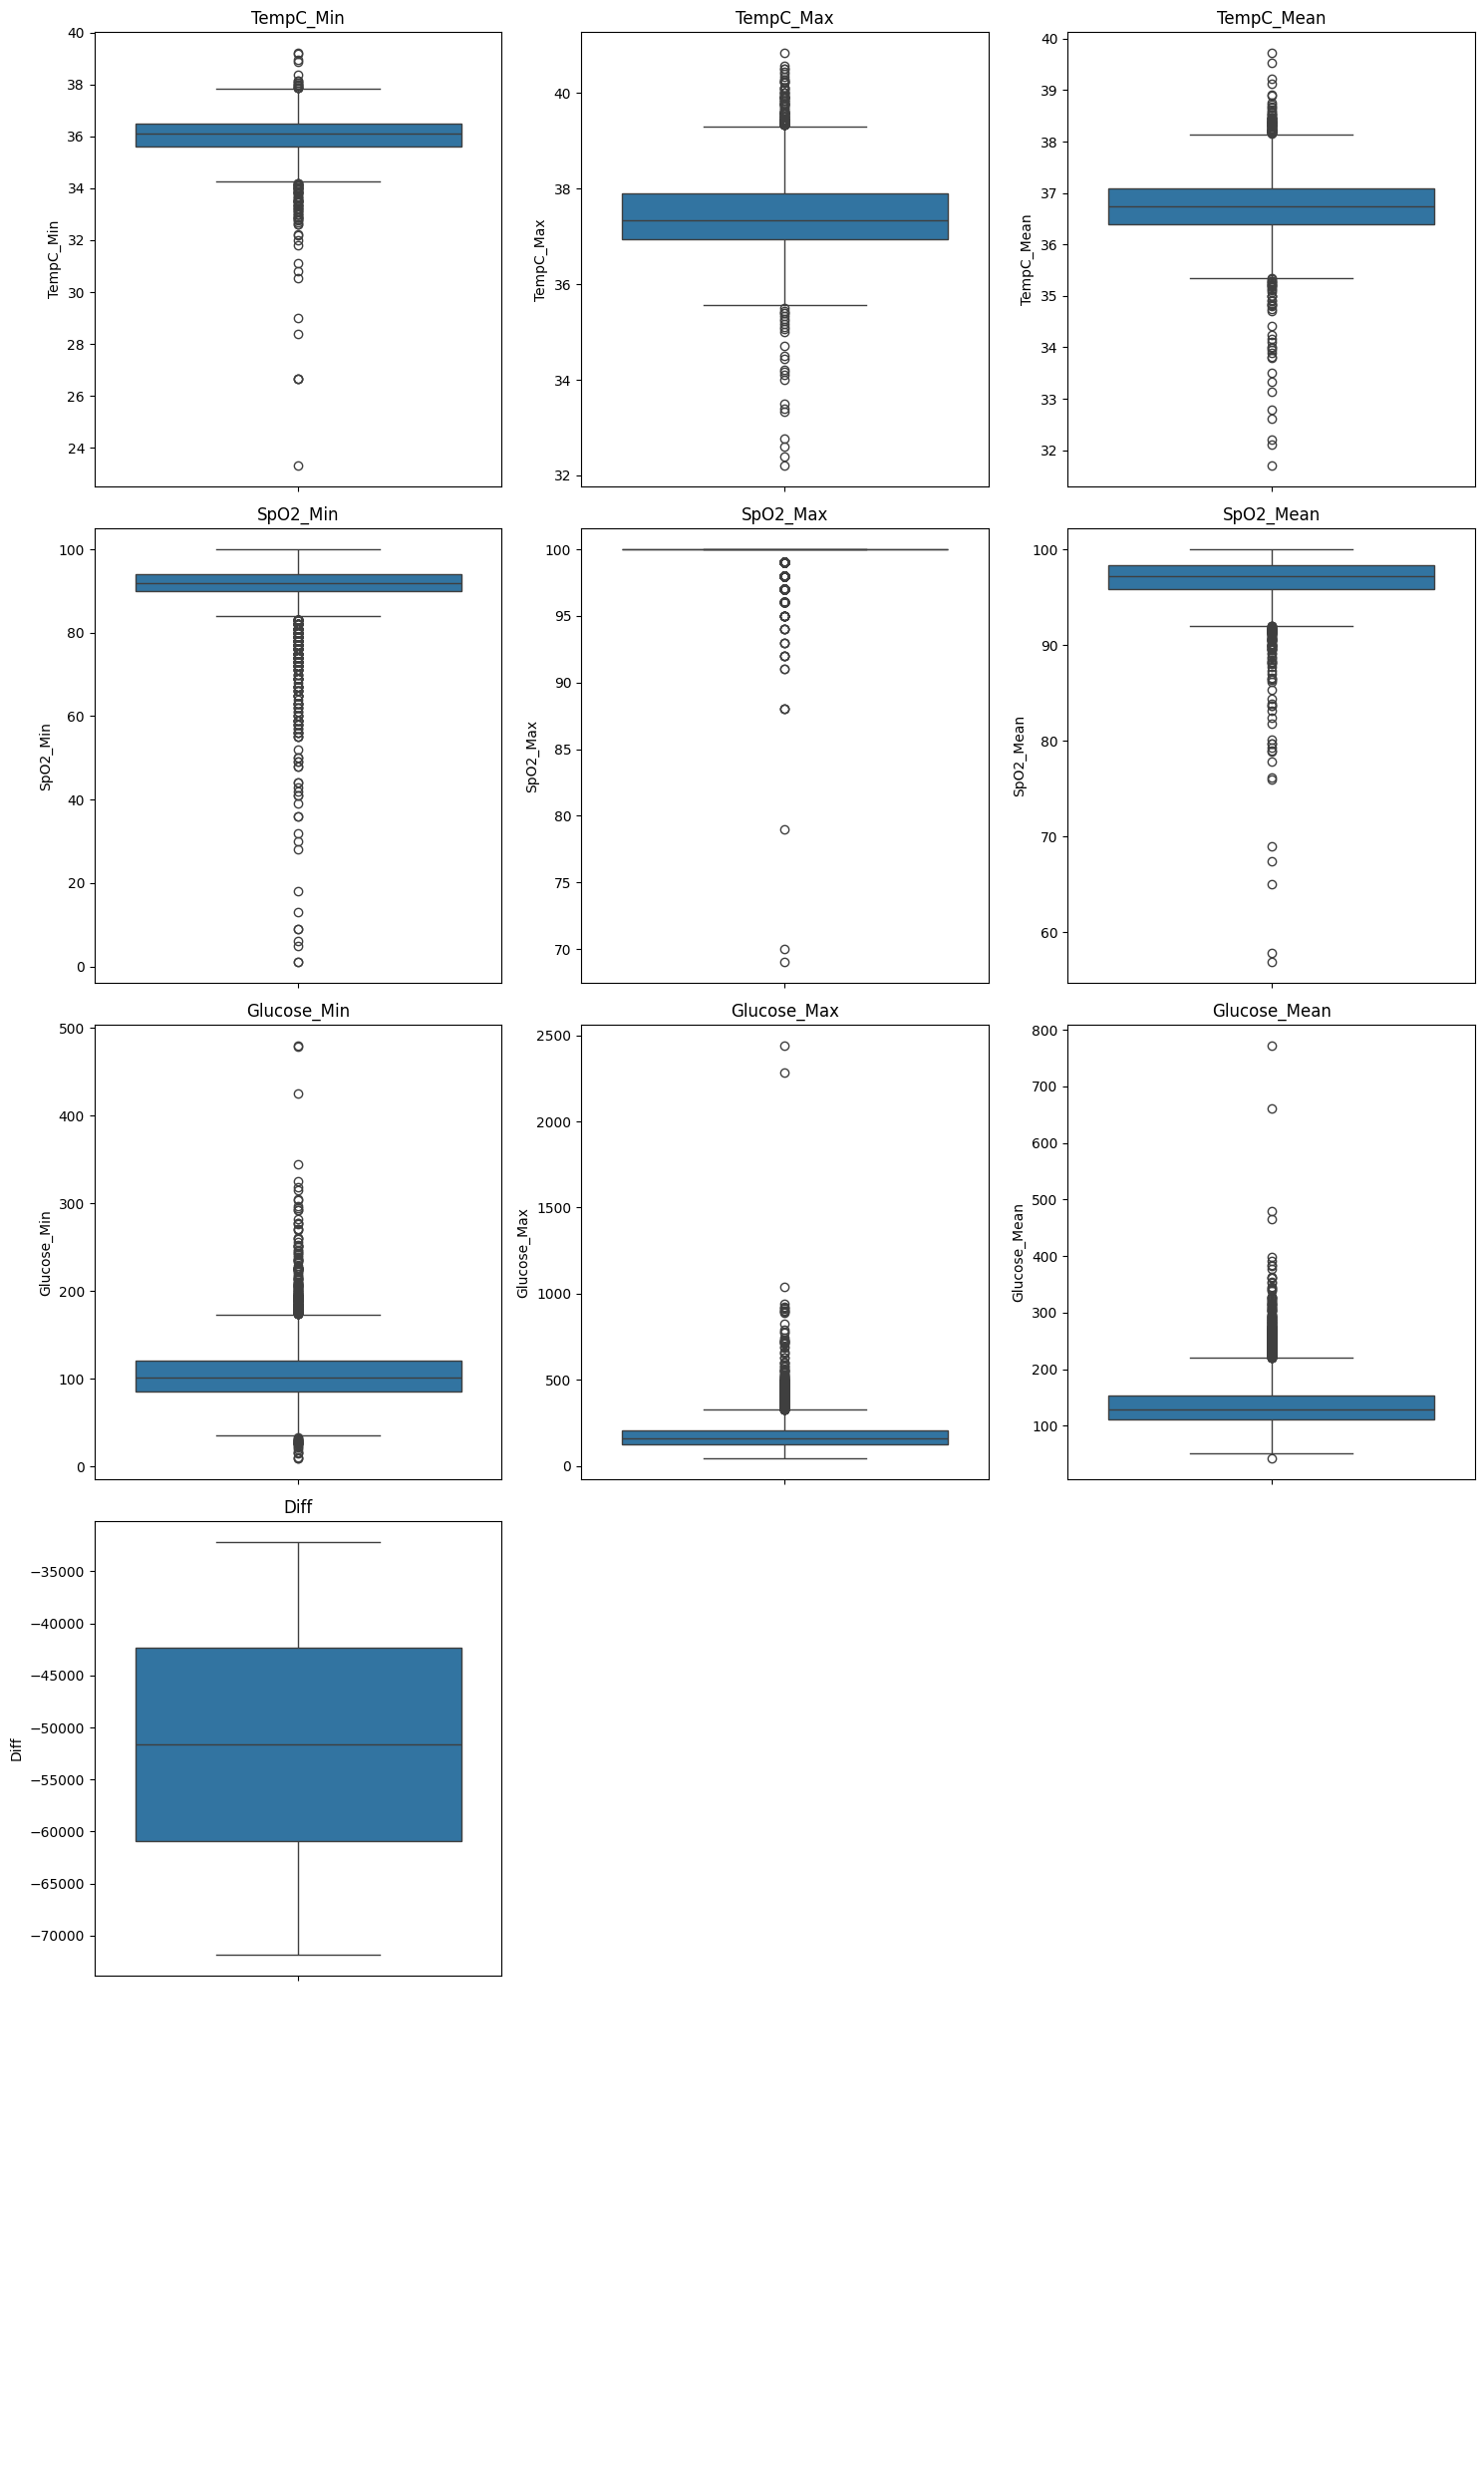

In [354]:
if EDA:
    num_features = train_model_clean[feature_cols].select_dtypes(include=np.number).columns.tolist()

    ncols = 3
    nrows = 5                     # fixed grid: 5 rows x 3 cols = 15 plots per figure
    plots_per_fig = nrows * ncols

    # 2. Loop over features in chunks of 15
    for start in range(0, len(num_features), plots_per_fig):
        subset = num_features[start:start + plots_per_fig]

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                                 figsize=(15, 5 * nrows))

        # Make axes always a flat 1D array for simple indexing
        axes = np.array(axes).ravel()

        # 3. Draw each boxplot
        for i, feat in enumerate(subset):
            ax = axes[i]

            # Optional: sample rows if dataset is big to speed up plotting
            data_to_plot = train[feat]
            if len(train_model_clean) > 5000:
                data_to_plot = data_to_plot.sample(5000, random_state=0)

            sns.boxplot(y=data_to_plot, ax=ax)
            ax.set_title(feat)

        # 4. Turn off any leftover empty axes
        for j in range(len(subset), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()


In [355]:
# Now we analyze the correlation matrix of the numerical columns

if EDA:
    corr = train_model_clean[num_features].corr()
    display(corr.style.background_gradient(cmap='coolwarm', axis=None).format("{:.4f}"))

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
HeartRate_Min,1.0000,0.5347,0.8360,0.0387,-0.1029,-0.0528,0.1687,0.0553,0.1896,0.1115,-0.0078,0.0979,0.2126,0.2198,0.2786,0.1720,0.2058,0.2319,0.0373,-0.0536,-0.0265,0.0284,0.0337,0.0395,-0.0038
HeartRate_Max,0.5347,1.0000,0.8154,-0.1480,0.0444,-0.0778,0.0437,0.1814,0.1763,-0.0477,0.1179,0.0949,0.1178,0.3315,0.2959,0.0655,0.2813,0.2127,-0.1303,0.0208,-0.0577,0.0239,0.0653,0.0631,-0.0034
HeartRate_Mean,0.8360,0.8154,1.0000,-0.0864,-0.0417,-0.0886,0.1098,0.1261,0.2062,0.0199,0.0639,0.1057,0.1824,0.3254,0.3445,0.1204,0.2779,0.2522,-0.0952,-0.0263,-0.0824,0.0334,0.0661,0.0692,-0.0009
SysBP_Min,0.0387,-0.1480,-0.0864,1.0000,0.3378,0.7463,0.5824,0.1763,0.4909,0.6757,0.0818,0.6084,0.0772,-0.1344,-0.0761,0.1729,-0.0239,0.0871,0.2088,-0.0669,0.0484,0.0933,-0.0307,0.0155,-0.0033
SysBP_Max,-0.1029,0.0444,-0.0417,0.3378,1.0000,0.7502,0.1538,0.5304,0.3630,0.2061,0.4811,0.5764,-0.0490,0.0386,-0.0184,0.0269,0.1096,0.0978,-0.0125,0.0518,0.0433,0.0438,0.0942,0.1011,-0.0184
SysBP_Mean,-0.0528,-0.0778,-0.0886,0.7463,0.7502,1.0000,0.4252,0.3967,0.5505,0.5121,0.3142,0.7761,0.0241,-0.0645,-0.0542,0.1212,0.0381,0.1051,0.1133,-0.0069,0.0540,0.0961,0.0528,0.0888,-0.0190
DiasBP_Min,0.1687,0.0437,0.1098,0.5824,0.1538,0.4252,1.0000,0.2407,0.7486,0.7478,0.1128,0.6905,0.0323,-0.0904,-0.0697,0.1391,-0.0011,0.0835,0.1642,-0.0631,0.0468,0.0405,-0.0599,-0.0362,0.0069
DiasBP_Max,0.0553,0.1814,0.1261,0.1763,0.5304,0.3967,0.2407,1.0000,0.5795,0.1786,0.5820,0.5494,0.0360,0.0914,0.0670,0.0288,0.0443,0.0403,-0.0437,-0.0038,-0.0217,0.0485,0.0169,0.0340,-0.0108
DiasBP_Mean,0.1896,0.1763,0.2062,0.4909,0.3630,0.5505,0.7486,0.5795,1.0000,0.5836,0.3242,0.9010,0.0537,-0.0054,0.0053,0.1094,0.0058,0.0650,0.0854,-0.0550,0.0081,0.0693,-0.0312,-0.0021,-0.0001
MeanBP_Min,0.1115,-0.0477,0.0199,0.6757,0.2061,0.5121,0.7478,0.1786,0.5836,1.0000,0.0719,0.6309,0.0296,-0.1192,-0.0926,0.1428,-0.0124,0.0820,0.1882,-0.0546,0.0584,0.0494,-0.0561,-0.0261,0.0037


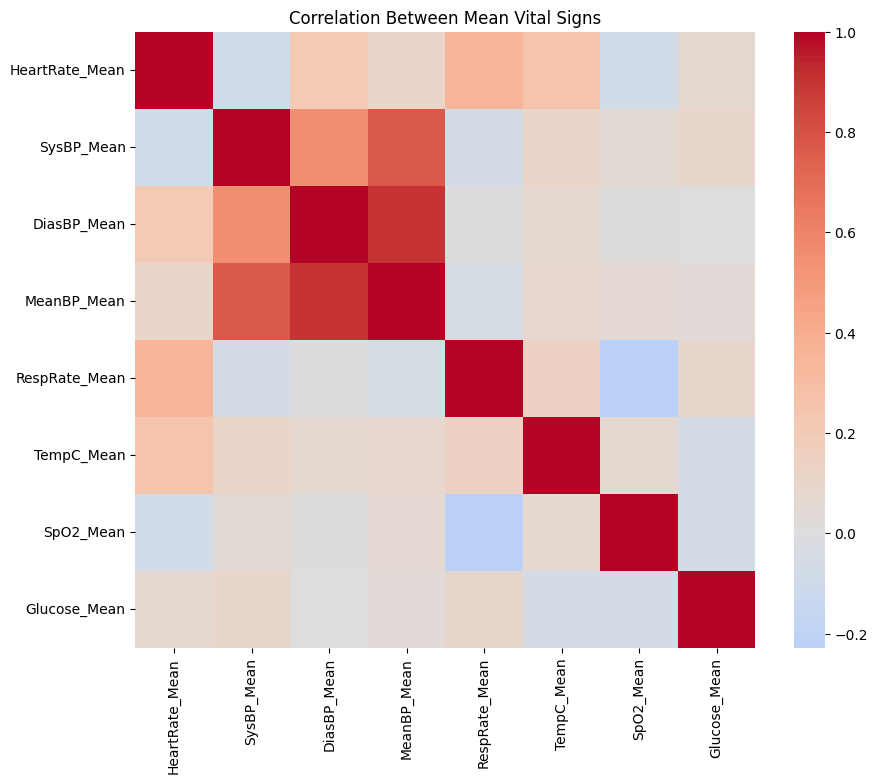

In [356]:
#focusing on vital means correlation heatmap

corr = train_model_clean[vital_means].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Between Mean Vital Signs")
plt.show()


Observations:
* Heart rate and respiration rate are moderately positively correlated
* Systolic, Diastolic BP and MeanBP are highly correlated, as expected
* SpO2 and Respiratory Rate are negatively correlated, as expected
* Heart rate and Respiration Rate and TempC are positively correlated
* Glucose is negatively correlated with Temperature and SpO2

In [357]:
# Mean vitals by survival vs death
grouped_vitals = (
    train_model_clean
    .groupby(target_col)[vital_means]
    .mean()
    .T
)

grouped_vitals


HOSPITAL_EXPIRE_FLAG,0,1
HeartRate_Mean,84.577185,89.954442
SysBP_Mean,119.908693,113.094355
DiasBP_Mean,62.901682,59.417750
MeanBP_Mean,78.058865,74.052180
RespRate_Mean,18.746174,20.882049
TempC_Mean,36.775155,36.562954
SpO2_Mean,96.996370,95.833809
Glucose_Mean,137.555563,151.281862


### 1.5 Analyze temporal patterns (age at admission, time-based features)

In [358]:
# Create function for age and time features (used later for test data)

def add_age_and_time_features(df):
    df = df.copy()
    # Convert to datetime
    df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], errors='coerce')

    df['AGE'] = np.nan
    validmask = df['DOB'].notna() & df['ADMITTIME'].notna()
    if validmask.any():
        dob = df.loc[validmask, 'DOB']
        admit = df.loc[validmask, 'ADMITTIME']

        years = admit.dt.year - dob.dt.year
        hadbirthday = (
            (admit.dt.month > dob.dt.month) |
            ((admit.dt.month == dob.dt.month) & (admit.dt.day >= dob.dt.day))
        )
        ageyears = years - (~hadbirthday).astype(int)
        df.loc[validmask, 'AGE'] = ageyears

    # clamp to [0,120]
    maskinvalid = (df['AGE'] < 0) | (df['AGE'] > 120)
    df.loc[maskinvalid, 'AGE'] = np.nan

    print(df["AGE"].describe())
    missing_mask = df["AGE"].isna()
    n_missing = missing_mask.sum()
    n_total = len(df)
    print(f"Missing AGE: {n_missing} / {n_total} ({n_missing/n_total:.3f})")

    # mortality among rows with missing AGE
    mortality_missing = df.loc[missing_mask, target_col].mean()
    # mortality among rows with known AGE
    mortality_known   = df.loc[~missing_mask, target_col].mean()

    print(f"Mortality (AGE missing): {mortality_missing:.3f}")
    print(f"Mortality (AGE known)  : {mortality_known:.3f}")

    # simple time features
    df['admit_hour'] = df['ADMITTIME'].dt.hour
    df['admit_weekday'] = df['ADMITTIME'].dt.dayofweek
    df['is_weekend'] = df['admit_weekday'].isin([5, 6]).astype(int)

    return df


count    17710.000000
mean        62.228120
std         16.429028
min         15.000000
25%         52.000000
50%         64.000000
75%         75.000000
max         89.000000
Name: AGE, dtype: float64
Missing AGE: 992 / 18702 (0.053)
Mortality (AGE missing): 0.167
Mortality (AGE known)  : 0.109
(18702, 44)


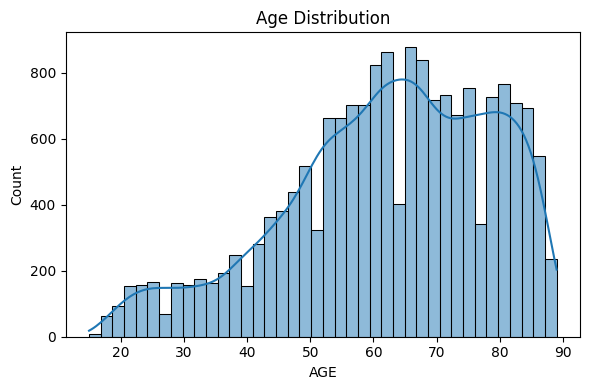

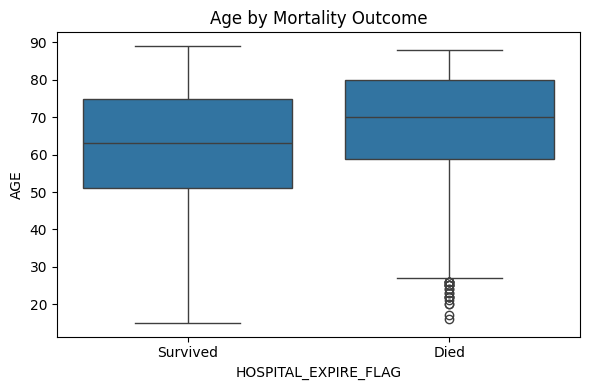

In [359]:
#apply function to clean train data and plot age distribution

train_base = add_age_and_time_features(train_model_clean)

print(train_base.shape)

plt.figure(figsize=(6,4))
sns.histplot(train_base["AGE"], bins=40, kde=True)
plt.title("Age Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=target_col, y="AGE", data=train_base)
plt.title("Age by Mortality Outcome")
plt.xticks([0, 1], ["Survived", "Died"])
plt.tight_layout()
plt.show()


### 1.6 Explore categorical variable distributions


=== GENDER ===
GENDER
M    0.560903
F    0.439097
Name: proportion, dtype: float64


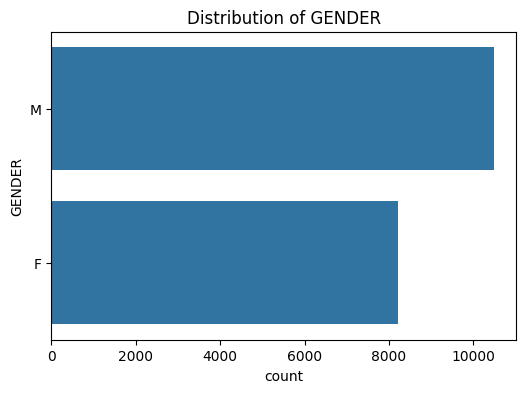


=== ADMISSION_TYPE ===
ADMISSION_TYPE
EMERGENCY    0.854989
ELECTIVE     0.134531
URGENT       0.010480
Name: proportion, dtype: float64


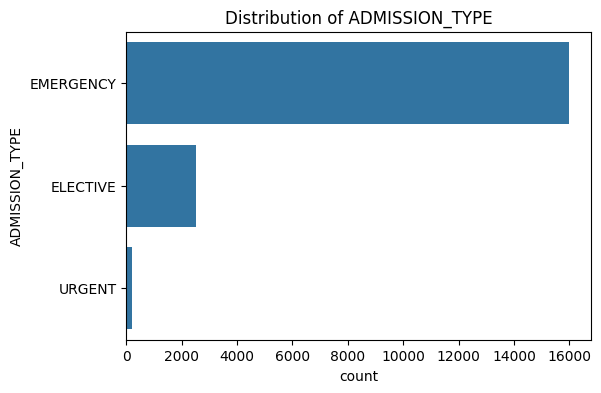


=== INSURANCE ===
INSURANCE
Medicare      0.561063
Private       0.296920
Medicaid      0.102663
Government    0.030211
Self Pay      0.009143
Name: proportion, dtype: float64


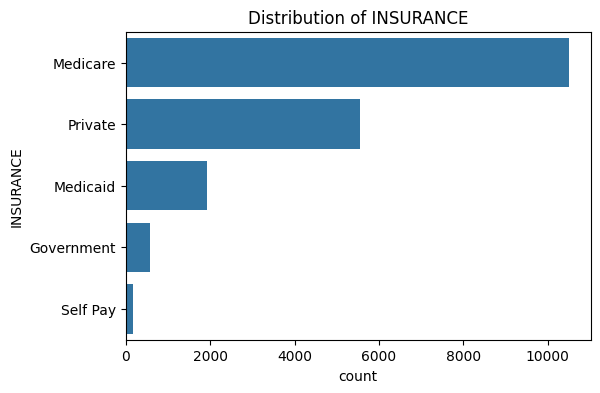


=== RELIGION ===
RELIGION
CATHOLIC               0.366111
NOT SPECIFIED          0.263608
PROTESTANT QUAKER      0.127045
JEWISH                 0.086622
UNOBTAINABLE           0.074324
OTHER                  0.032938
EPISCOPALIAN           0.014009
GREEK ORTHODOX         0.008448
CHRISTIAN SCIENTIST    0.008288
BUDDHIST               0.005133
Name: proportion, dtype: float64


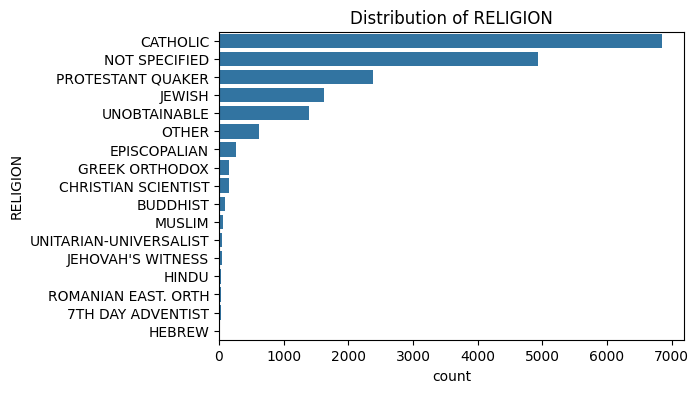


=== MARITAL_STATUS ===
MARITAL_STATUS
MARRIED              0.478384
SINGLE               0.295854
WIDOWED              0.137466
DIVORCED             0.070703
SEPARATED            0.011654
UNKNOWN (DEFAULT)    0.005217
LIFE PARTNER         0.000721
Name: proportion, dtype: float64


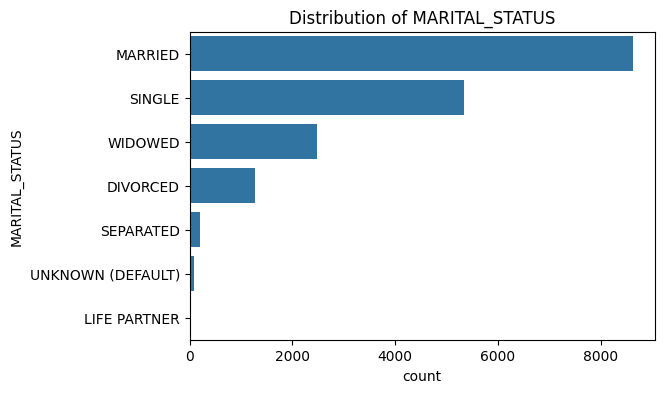


=== ETHNICITY ===
ETHNICITY
WHITE                             0.717731
BLACK/AFRICAN AMERICAN            0.095765
UNABLE TO OBTAIN                  0.029302
UNKNOWN/NOT SPECIFIED             0.028232
HISPANIC OR LATINO                0.027216
OTHER                             0.024543
ASIAN                             0.012191
PATIENT DECLINED TO ANSWER        0.008555
HISPANIC/LATINO - PUERTO RICAN    0.007272
ASIAN - CHINESE                   0.007165
Name: proportion, dtype: float64


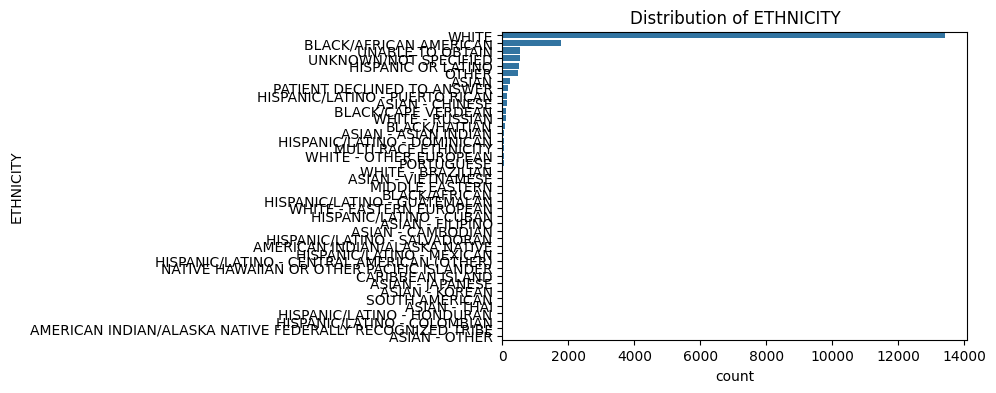

In [360]:
for col in demographic_cols:
    if col in train_base.columns:
        print(f"\n=== {col} ===")
        print(train_base[col].value_counts(normalize=True).head(10))

        plt.figure(figsize=(6,4))
        sns.countplot(
            y=col,
            data=train_base,
            order=train_base[col].value_counts().index
        )
        plt.title(f"Distribution of {col}")
        plt.show()



Mortality rate by GENDER:
GENDER
F    0.116293
M    0.108961
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64


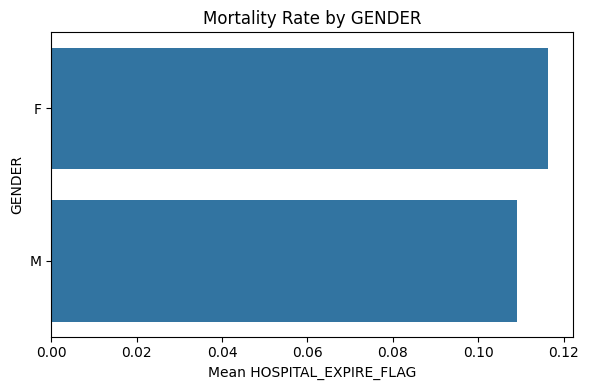


Mortality rate by ETHNICITY:
ETHNICITY
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE    0.500000
ASIAN - JAPANESE                                            0.333333
ASIAN - CAMBODIAN                                           0.285714
UNKNOWN/NOT SPECIFIED                                       0.212121
ASIAN - KOREAN                                              0.200000
UNABLE TO OBTAIN                                            0.198905
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER                   0.166667
ASIAN - VIETNAMESE                                          0.148148
ASIAN                                                       0.144737
PORTUGUESE                                                  0.131579
MULTI RACE ETHNICITY                                        0.127660
WHITE - RUSSIAN                                             0.127273
ASIAN - CHINESE                                             0.119403
WHITE - EASTERN EUROPEAN                                    0.1

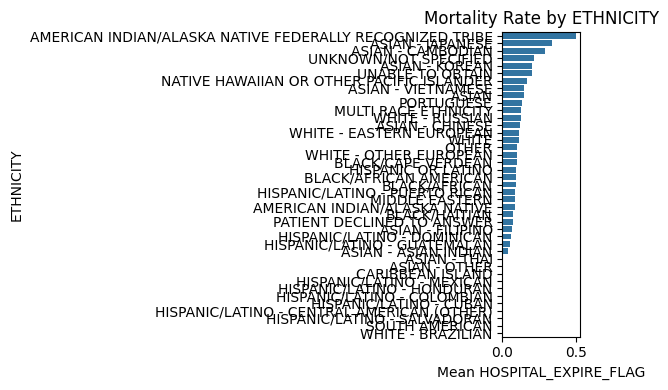


Mortality rate by INSURANCE:
INSURANCE
Self Pay      0.134503
Medicare      0.134280
Private       0.086620
Medicaid      0.079167
Government    0.058407
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64


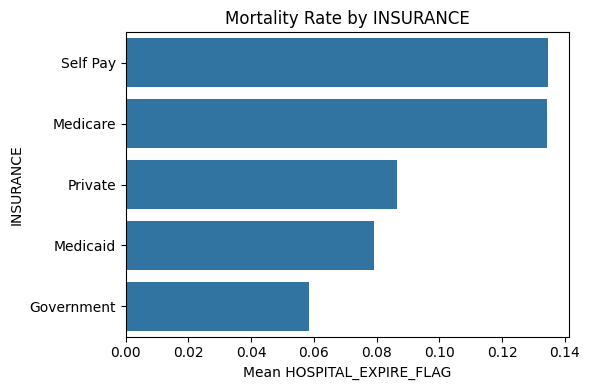


Mortality rate by FIRST_CAREUNIT:
FIRST_CAREUNIT
MICU     0.139273
SICU     0.116984
CCU      0.108245
TSICU    0.101424
CSRU     0.036090
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64


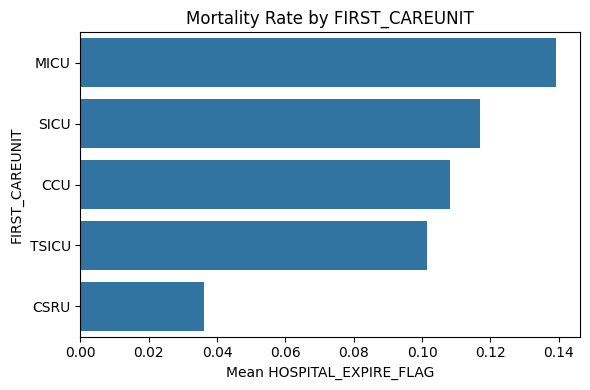

In [361]:
#checking specific key categories against target
cat_for_target = ["GENDER","ETHNICITY","INSURANCE", "FIRST_CAREUNIT"]

for col in cat_for_target:
    if col in train_base.columns:
        # Mortality rate by category
        rate = (
            train_base
            .groupby(col)[target_col]
            .mean()
            .sort_values(ascending=False)
        )
        print(f"\nMortality rate by {col}:")
        print(rate)

        plt.figure(figsize=(6,4))
        sns.barplot(x=rate.values, y=rate.index)
        plt.title(f"Mortality Rate by {col}")
        plt.xlabel("Mean HOSPITAL_EXPIRE_FLAG")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()


### 1.7 Diagnoses Extra Data EDA

In [362]:

# Load diagnoses file
MIMIC_diagnoses = pd.read_csv("MIMIC III dataset HEF/extra_data/MIMIC_diagnoses.csv")

MIMIC_diagnoses.head()
MIMIC_diagnoses.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   SUBJECT_ID  651047 non-null  int64  
 1   HADM_ID     651047 non-null  int64  
 2   SEQ_NUM     651000 non-null  float64
 3   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 19.9+ MB


#### 1.7.1 Creating diagnoses feature fitting for train data only

In [372]:

#restrict diagnoses to only those in train_model_clean

def fit_diagnosis_features(train_df, diagnoses_df):
    df = train_df.copy()
    
    # Restrict diagnoses to hadm_id present in train
    diagnoses_train = diagnoses_df[diagnoses_df['HADM_ID'].isin(df['hadm_id'])].copy()

    # Merge labels
    diagnoses_train = diagnoses_train.merge(
        df[['hadm_id', 'HOSPITAL_EXPIRE_FLAG']],
        left_on='HADM_ID', 
        right_on='hadm_id', 
        how='left'
    )

    # Count diagnoses per admission
    diagnoses_counts = diagnoses_train.groupby('hadm_id').size().reset_index(name='diagnosis_count')

    # Mortality per ICD9
    severity = (
        diagnoses_train
        .groupby('ICD9_CODE')['HOSPITAL_EXPIRE_FLAG']
        .agg(['sum', 'count'])
        .rename(columns={'sum': 'n_deaths', 'count': 'n_patients'})
    )
    overall_mort = df['HOSPITAL_EXPIRE_FLAG'].mean()
    alpha = 10

    severity['raw_mortality'] = severity['n_deaths'] / severity['n_patients']
    severity['smoothed_severity'] = (
        (severity['n_patients'] * severity['raw_mortality'] + alpha * overall_mort)
        / (severity['n_patients'] + alpha)
    )

    # Save mapping for later use
    severity_map = severity['smoothed_severity'].to_dict()

    # Attach severity to all diagnoses
    diagnoses_train['severity'] = diagnoses_train['ICD9_CODE'].map(severity_map)
    diagnoses_train['severity'] = diagnoses_train['severity'].fillna(overall_mort)

    # Aggregate per hadm_id
    sev_agg = diagnoses_train.groupby('hadm_id')['severity'].agg(
        avg_diagnosis_severity='mean',
        max_diagnosis_severity='max'
    ).reset_index()  # ← RESET INDEX HERE

    # Primary diagnosis severity
    primary = diagnoses_train[diagnoses_train['SEQ_NUM'] == 1].copy()
    primary = (primary
               .groupby('hadm_id')['severity']
               .first()  # In case multiple primaries (shouldn't happen but safeguard)
               .reset_index()
               .rename(columns={'severity': 'primary_diagnosis_severity'}))

    # merge features back to df
    df = df.merge(diagnoses_counts, on='hadm_id', how='left')
    df = df.merge(sev_agg, on='hadm_id', how='left')
    df = df.merge(primary, on='hadm_id', how='left')

    # Fill missing (no diagnoses)
    df['diagnosis_count'] = df['diagnosis_count'].fillna(0)
    for col in ['avg_diagnosis_severity', 'max_diagnosis_severity', 'primary_diagnosis_severity']:
        df[col] = df[col].fillna(overall_mort)

    # Pack state
    state = {
        'severity_map': severity_map,
        'overall_mort': overall_mort,
        'alpha': alpha,
    }
    return df, state



#### Severity Quick Comments

**Severity** = mortality risk score per ICD9 diagnosis code

**How it's calculated:**
1. For each ICD9 code in the training data, compute the proportion of patients who died
2. Apply Bayesian smoothing to balance observed rates with the overall mortality rate
3. Rare diagnoses (few patients) shrink toward the average; common diagnoses stay close to observed rates

**Why Bayesian smoothing?**
- Prevents extreme estimates: A rare code with 1 patient who died would have raw mortality = 100%, which is unreliable. With smoothing (α=10), that becomes: (1 × 1.0 + 10 × 0.112) / 11 ≈ 0.19 (more conservative). Common codes with 100+ patients are barely affected by the prior

**α = 10 interpretation:**
- Acts like adding 10 "virtual patients" with average mortality to every ICD9 code
- Balances between observed data (for common codes) and prior knowledge (for rare codes)

Each ICD9 code gets a severity score between 0 (low mortality risk) and 1 (high mortality risk)

In [373]:
# apply to clean train data
train_base, diag_state = fit_diagnosis_features(train_model_clean, MIMIC_diagnoses)



In [374]:
print(train_base.shape, train_model_clean.shape)

(18702, 44) (18702, 40)


#### 1.7.2 Function to apply diagnoses severity features to test data later on

In [375]:
## apply to test data function

def apply_diagnosis_features(df, diagnoses_df, state):
    df = df.copy()
    severity_map = state['severity_map']
    overall_mort = state['overall_mort']

    diag = diagnoses_df[diagnoses_df['HADM_ID'].isin(df['hadm_id'])].copy()

    diag['severity'] = diag['ICD9_CODE'].map(severity_map)
    diag['severity'] = diag['severity'].fillna(overall_mort)

    diag_counts = diag.groupby('hadm_id').size().rename('diagnosis_count')
    sev_agg = diag.groupby('hadm_id')['severity'].agg(
        avg_diagnosis_severity='mean',
        max_diagnosis_severity='max'
    )
    primary = diag[diag['SEQ_NUM'] == 1].copy()
    primary = primary.set_index('hadm_id')['severity'].rename('primary_diagnosis_severity')

    df = df.join(diag_counts, on='hadm_id')
    df = df.join(sev_agg, on='hadm_id')
    df = df.join(primary, on='hadm_id')

    df['diagnosis_count'] = df['diagnosis_count'].fillna(0)
    for col in ['avg_diagnosis_severity', 'max_diagnosis_severity', 'primary_diagnosis_severity']:
        df[col] = df[col].fillna(overall_mort)

    return df


#### 1.7.3 Distribution of diagnoses per patient at admission

=== Diagnoses per ICU Stay (Training Data) ===

count    17682.000000
mean        14.712589
std          7.116113
min          1.000000
25%          9.000000
50%         14.000000
75%         19.000000
max         39.000000
dtype: float64

Median: 14 diagnoses
Range: 1 to 39 diagnoses


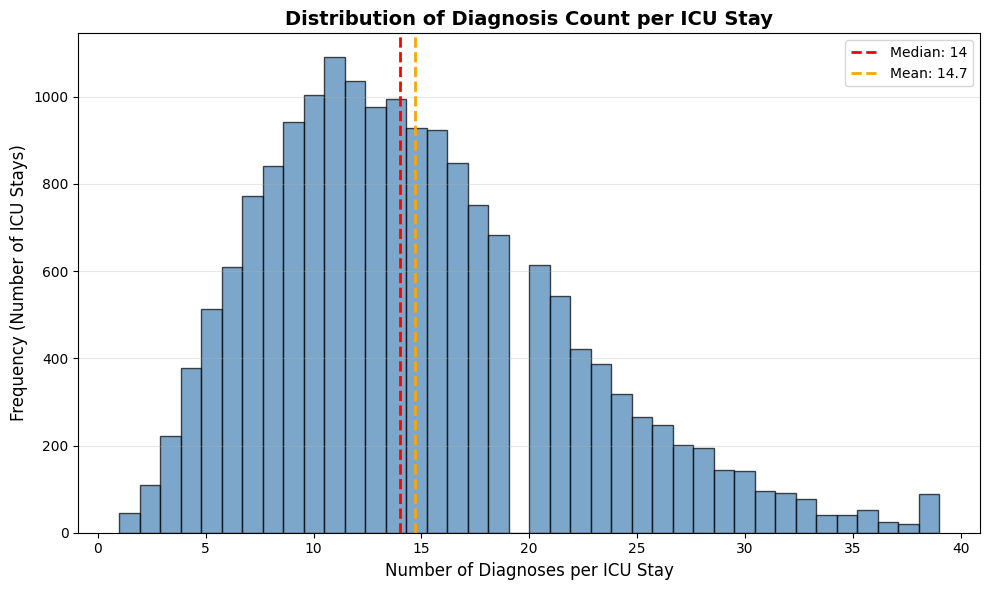

In [376]:
# Distribution of Diagnoses per Patient

# Filter diagnoses to training admissions only
train_hadm = set(train_base['hadm_id'])
diag_train = MIMIC_diagnoses[MIMIC_diagnoses['HADM_ID'].isin(train_hadm)].copy()

# Count diagnoses per admission
diag_per_patient = diag_train.groupby('HADM_ID').size()

print("=== Diagnoses per ICU Stay (Training Data) ===\n")
print(diag_per_patient.describe())
print(f"\nMedian: {diag_per_patient.median():.0f} diagnoses")
print(f"Range: {diag_per_patient.min():.0f} to {diag_per_patient.max():.0f} diagnoses")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(diag_per_patient, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Number of Diagnoses per ICU Stay', fontsize=12)
plt.ylabel('Frequency (Number of ICU Stays)', fontsize=12)
plt.title('Distribution of Diagnosis Count per ICU Stay', fontsize=14, fontweight='bold')
plt.axvline(diag_per_patient.median(), color='red', linestyle='--', linewidth=2,
            label=f'Median: {diag_per_patient.median():.0f}')
plt.axvline(diag_per_patient.mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Mean: {diag_per_patient.mean():.1f}')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


##### Observation: Diagnosis Volume

- **Median:** ~14 diagnoses per ICU stay
- **Range:** 1 to 39 diagnoses
- **Distribution:** Right-skewed; most patients have 10-20 diagnoses
- **Interpretation:** 
  - Patients with very few diagnoses may represent simpler cases, shorter stays
  - Patients with many diagnoses likely have complex, multi-system conditions
  - Diagnosis count is likely a good proxy for patient complexity/severity

#### 1.7.4 Most Common Primary Diagnoses


=== Top 20 Primary Diagnoses with Descriptions ===

ICD9_CODE  count           SHORT_DIAGNOSE
    41401    913 Crnry athrscl natve vssl
     0389    833           Septicemia NOS
     4241    442    Aortic valve disorder
    41071    437 Subendo infarct, initial
      431    373 Intracerebral hemorrhage
    51881    344 Acute respiratry failure
      486    292  Pneumonia, organism NOS
     5070    238   Food/vomit pneumonitis
      430    195  Subarachnoid hemorrhage
    42823    193  Ac on chr syst hrt fail
    42833    180 Ac on chr diast hrt fail
     5849    178 Acute kidney failure NOS
     5789    174  Gastrointest hemorr NOS
     1983    164  Sec mal neo brain/spine
     4240    158    Mitral valve disorder
    25013    152   DMI ketoacd uncontrold
    42731    151      Atrial fibrillation
    43411    149     Crbl emblsm w infrct
     5770    139       Acute pancreatitis
    41519    136   Pulm embol/infarct NEC

Top 20 codes cover 33.0% of all primary diagnoses


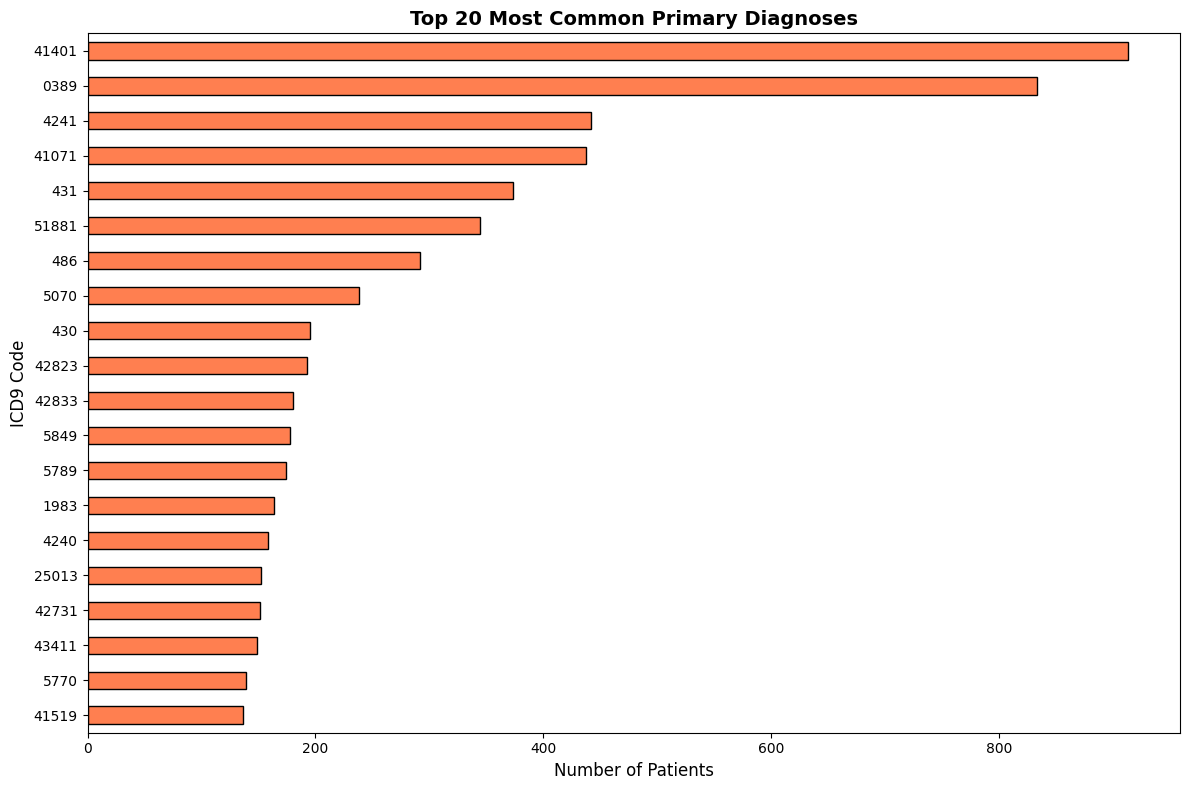

In [377]:
# Most Common Primary Diagnoses

# Extract primary diagnoses (SEQ_NUM == 1)
primary_diag = diag_train[diag_train['SEQ_NUM'] == 1].copy()

# Top 20 most frequent primary ICD9 codes
top_20_primary = primary_diag['ICD9_CODE'].value_counts().head(20)

metadata = pd.read_csv("MIMIC III dataset HEF/extra_data/MIMIC_metadata_diagnose.csv")
top_20_df = top_20_primary.reset_index()
top_20_df.columns = ['ICD9_CODE', 'count']

top_20_with_names = top_20_df.merge(
    metadata[['ICD9_CODE', 'SHORT_DIAGNOSE']], 
    on='ICD9_CODE', 
    how='left'
)

print("\n=== Top 20 Primary Diagnoses with Descriptions ===\n")
print(top_20_with_names.to_string(index=False))

# Calculate coverage
total_primary = len(primary_diag)
top_20_coverage = (top_20_primary.sum() / total_primary) * 100
print(f"\nTop 20 codes cover {top_20_coverage:.1f}% of all primary diagnoses")




# Plot
plt.figure(figsize=(12, 8))
top_20_primary.sort_values().plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Number of Patients', fontsize=12)
plt.ylabel('ICD9 Code', fontsize=12)
plt.title('Top 20 Most Common Primary Diagnoses', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


##### Observation: Primary Diagnoses

- **Top 20 codes** represent the most common critical care admission reasons
- These 20 codes account for **33%** of all primary diagnoses (check output)
- **Considerations for Model**
  - Common codes have reliable mortality statistics
  - Rare codes (appearing <10 times) will benefit from Bayesian smoothing (further supporting rationale to use Bayesian smoothing)
  - Will likely one-hot encode top N (TBD) primary diagnoses as additional features

#### 1.7.5 Diagnosis and Mortality Exploration

Mortality Rate by Diagnosis Count

          mortality_rate  n_patients
diag_bin                            
1-5             0.041303        1259
6-10            0.061363        4123
11-15           0.085331        4922
16-20           0.117281        3692
21-25           0.153971        1851
26+             0.187050        1807

Overall mortality rate: 0.112


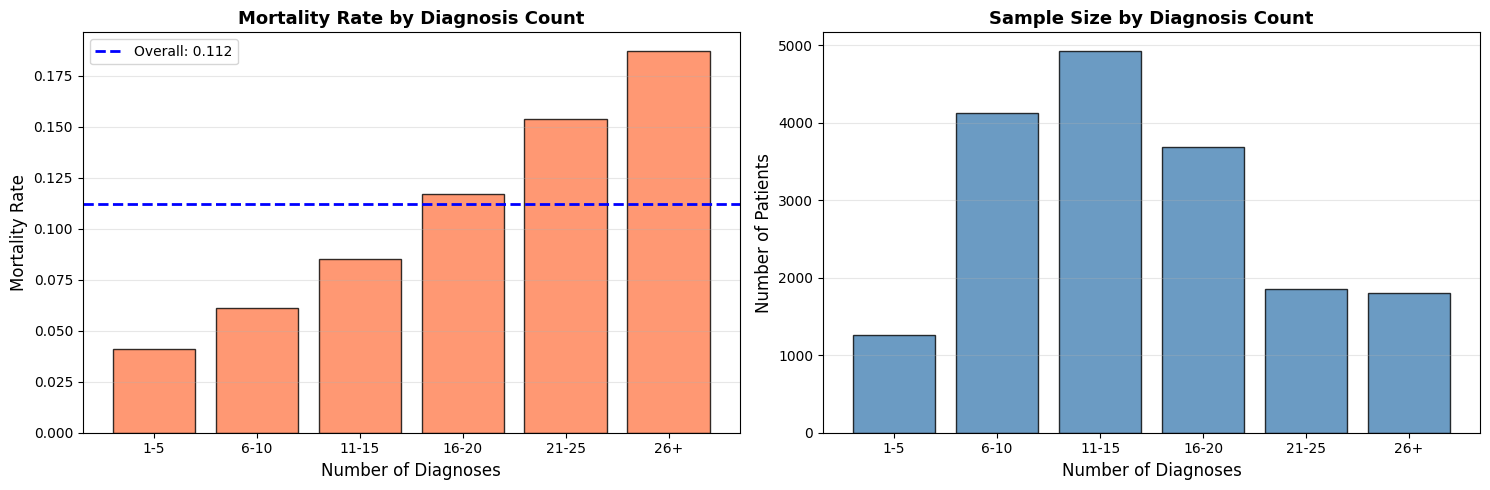

In [378]:
train_with_counts = train_base[['hadm_id', 'HOSPITAL_EXPIRE_FLAG', 'diagnosis_count']].copy()

# Bin diagnosis count
train_with_counts['diag_bin'] = pd.cut(
    train_with_counts['diagnosis_count'],
    bins=[0, 5, 10, 15, 20, 25, 40],
    labels=['1-5', '6-10', '11-15', '16-20', '21-25', '26+']
)

# Mortality rate by bin
mortality_by_count = (
    train_with_counts
    .groupby('diag_bin', observed=True)['HOSPITAL_EXPIRE_FLAG']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'mortality_rate', 'count': 'n_patients'})
)

print("Mortality Rate by Diagnosis Count\n")
print(mortality_by_count)
print(f"\nOverall mortality rate: {train_base['HOSPITAL_EXPIRE_FLAG'].mean():.3f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mortality rate
axes[0].bar(mortality_by_count.index.astype(str), 
            mortality_by_count['mortality_rate'], 
            color='coral', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Number of Diagnoses', fontsize=12)
axes[0].set_ylabel('Mortality Rate', fontsize=12)
axes[0].set_title('Mortality Rate by Diagnosis Count', fontsize=13, fontweight='bold')
axes[0].axhline(train_base['HOSPITAL_EXPIRE_FLAG'].mean(), 
                color='blue', linestyle='--', linewidth=2, 
                label=f"Overall: {train_base['HOSPITAL_EXPIRE_FLAG'].mean():.3f}")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Sample size
axes[1].bar(mortality_by_count.index.astype(str), 
            mortality_by_count['n_patients'], 
            color='steelblue', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Number of Diagnoses', fontsize=12)
axes[1].set_ylabel('Number of Patients', fontsize=12)
axes[1].set_title('Sample Size by Diagnosis Count', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


##### comment

- **Clear trend:** Mortality rate increases with diagnosis count
- **Low count (1-5):** Lowest mortaility rate at 4.1%
- **High count (26+):** Highest mortality rate at 18.7%
- **Interpretation:**
  - More diagnoses → more complex/severe medical conditions
  - `diagnosis_count` is a valuable predictor for mortality risk 
  - Very low counts may indicate coding issues or very short stays, but should stil watch out for few counts, but high severity diagnoses.


#### 1.7.6 Diagnosis Severity vs Mortaility



Mortality Rate by Average Diagnosis Severity Quartile

                   mortality_rate  n_patients
severity_quartile                            
Q1 (Low)                 0.000855        4676
Q2                       0.005989        4675
Q3                       0.051979        4675
Q4 (High)                0.389863        4676


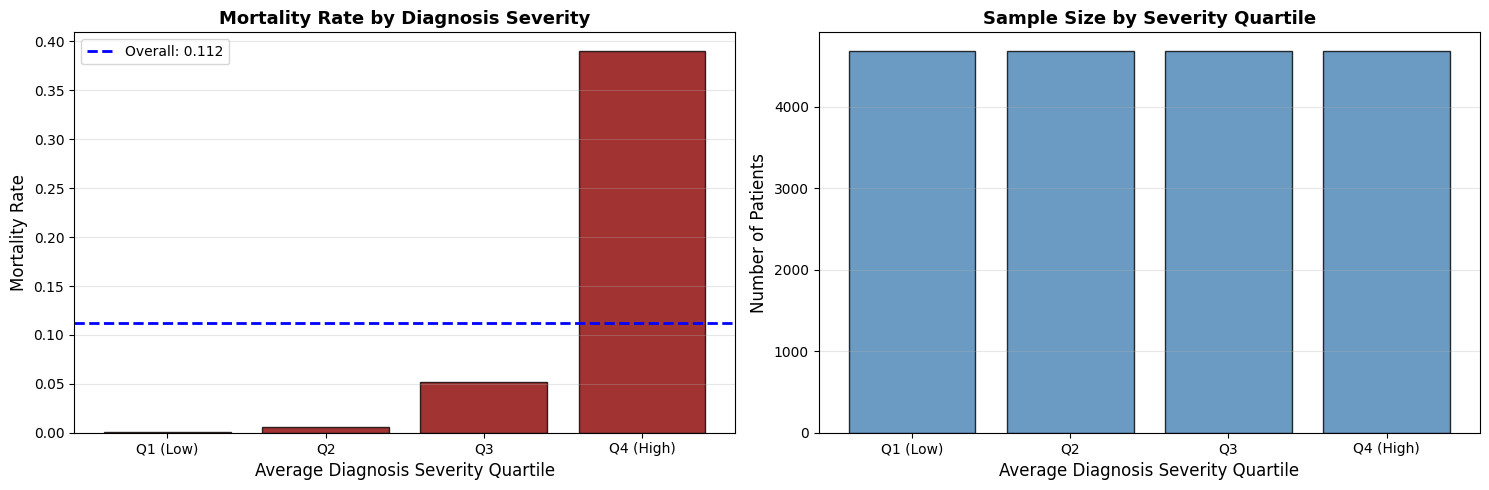


Diagnosis Severity Feature Ranges

       avg_diagnosis_severity  max_diagnosis_severity  \
count            18702.000000            18702.000000   
mean                 0.136222                0.283047   
std                  0.038280                0.129671   
min                  0.020923                0.020923   
25%                  0.109484                0.189268   
50%                  0.129321                0.253352   
75%                  0.156380                0.351260   
max                  0.399341                0.713607   

       primary_diagnosis_severity  
count                18702.000000  
mean                     0.154454  
std                      0.090604  
min                      0.018094  
25%                      0.087289  
50%                      0.132649  
75%                      0.208104  
max                      0.713607  
(18702, 44)


In [379]:
# Pulling from function fit_diagnosis_features() created to pull diagnosis severity features into clean train data 
severity_cols = ['avg_diagnosis_severity', 'max_diagnosis_severity', 
                 'primary_diagnosis_severity']

# Check if severity features exist
if all(col in train_base.columns for col in severity_cols):
    
    train_with_sev = train_base[['HOSPITAL_EXPIRE_FLAG'] + severity_cols].copy()
    
    # Bin by avg severity quartiles
    train_with_sev['severity_quartile'] = pd.qcut(
        train_with_sev['avg_diagnosis_severity'],
        q=4,
        labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'],
        duplicates='drop'
    )
    
    mortality_by_sev = (
        train_with_sev
        .groupby('severity_quartile', observed=True)['HOSPITAL_EXPIRE_FLAG']
        .agg(['mean', 'count'])
        .rename(columns={'mean': 'mortality_rate', 'count': 'n_patients'})
    )
    
    print("Mortality Rate by Average Diagnosis Severity Quartile\n")
    print(mortality_by_sev)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Mortality by quartile
    axes[0].bar(mortality_by_sev.index.astype(str), 
                mortality_by_sev['mortality_rate'],
                color='darkred', edgecolor='black', alpha=0.8)
    axes[0].set_xlabel('Average Diagnosis Severity Quartile', fontsize=12)
    axes[0].set_ylabel('Mortality Rate', fontsize=12)
    axes[0].set_title('Mortality Rate by Diagnosis Severity', fontsize=13, fontweight='bold')
    axes[0].axhline(train_base['HOSPITAL_EXPIRE_FLAG'].mean(), 
                    color='blue', linestyle='--', linewidth=2,
                    label=f"Overall: {train_base['HOSPITAL_EXPIRE_FLAG'].mean():.3f}")
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Sample size
    axes[1].bar(mortality_by_sev.index.astype(str), 
                mortality_by_sev['n_patients'],
                color='steelblue', edgecolor='black', alpha=0.8)
    axes[1].set_xlabel('Average Diagnosis Severity Quartile', fontsize=12)
    axes[1].set_ylabel('Number of Patients', fontsize=12)
    axes[1].set_title('Sample Size by Severity Quartile', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional: Show range of severity values
    print("\nDiagnosis Severity Feature Ranges\n")
    print(train_base[severity_cols].describe())
    
else:
    print("Severity features not yet computed. Run fit_diagnosis_features() first.")

print(train_base.shape)